<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Scaling-Up-with-Galaxy" data-toc-modified-id="Scaling-Up-with-Galaxy-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Scaling Up with Galaxy</a></span><ul class="toc-item"><li><span><a href="#Exploring-Galaxy-Structure" data-toc-modified-id="Exploring-Galaxy-Structure-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Exploring Galaxy Structure</a></span></li><li><span><a href="#Getting-Dataset-IDs" data-toc-modified-id="Getting-Dataset-IDs-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Getting Dataset IDs</a></span></li><li><span><a href="#Transferring-Bmap-Datasets" data-toc-modified-id="Transferring-Bmap-Datasets-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Transferring Bmap Datasets</a></span></li><li><span><a href="#Transferring-Genome/Transcriptome-Data" data-toc-modified-id="Transferring-Genome/Transcriptome-Data-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Transferring Genome/Transcriptome Data</a></span></li><li><span><a href="#Galaxy-QC" data-toc-modified-id="Galaxy-QC-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Galaxy QC</a></span></li><li><span><a href="#Post-Trim-Quality" data-toc-modified-id="Post-Trim-Quality-1.6"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>Post-Trim Quality</a></span></li><li><span><a href="#Mapping-Reads-to-Transcripts" data-toc-modified-id="Mapping-Reads-to-Transcripts-1.7"><span class="toc-item-num">1.7&nbsp;&nbsp;</span>Mapping Reads to Transcripts</a></span></li></ul></li></ul></div>

**Table of Contents**
<div id="toc"></div>

In [1]:
import Bio
import json
import locale
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import platform
import shutil
import sys
import webbrowser
# Necessary to set font family for Latex in matplotlib:
from matplotlib import rc

locale.setlocale(locale.LC_ALL, '')
o_s = platform.system()
paths = {}

# to make this notebook's output stable across runs
np.random.seed(42)

if o_s == 'Darwin':
    paths['data_dir'] = '/Users/drew/data/Bio'
    paths['sra_tools_dir'] = '/Users/drew/Documents/Data/Bio/\
sratoolkit/bin'
    paths['fastqc'] = '/Applications/FastQC.app/Contents/MacOS/fastqc'
    paths['bbmap_dir'] = '/Users/drew/Documents/Data/Python/bbmap'
    
elif o_s == 'Windows':
    paths['data_dir'] = r'C:\Users\DMacKellar\Documents\Data\Bio\Bmap'
    paths['sra_tools_dir'] = r'C:\Users\DMacKellar\Documents\\
Python\BioPython\Galaxy_rnaseq\sratoolkit\sratoolkit.2.8.2-1-win64\bin'
    paths['fastqc_dir'] = r'C:\Users\DMacKellar\Documents\Python\BioPython\FastQC'
    paths['multiqc_dir'] = r'C:\Users\DMacKellar\Documents\Python\BioPython\MultiQC'
    paths['jdk_dir'] = r'C:\Program Files\Java\jdk1.8.0_101'
    paths['bzip_dir'] = r'C:\Users\DMacKellar\Documents\Python\BioPython\Glimmer\Glimmer-master\src\main\java'
    paths['bbmap_dir'] = r'C:\Users\DMacKellar\Documents\Python\BioPython\BBMap'
    paths['phi_x'] = r'C:/Users/DMacKellar/Documents/Python/BioPython/BBMap/resources/phix174_ill.ref.fa'
    paths['grch38_dir'] = os.path.join(paths['data_dir'], 'grch38')

# rc('font',**{'family':'serif','serif':['DejaVu Sans']})
rc('text', usetex=False)

for root, dirs, files in os.walk(paths['data_dir']):
    for file in files:
        file_under = str(file).replace('.', '_')
        path = os.path.join(root, file)
        paths[file_under] = path
        
sra_table = pd.read_csv(paths['Bmap_SraRunTable_txt'], sep='\t')
paths['credentials_json'] = os.path.join(paths['data_dir'], 'credentials.json')
with open(paths['credentials_json'], 'r') as f:
    credentials = json.load(f)

# Scaling Up with Galaxy

Given that my laptop's RAM doesn't even successfully index the reference sequence of many human chromosomes with BBMap, it's clear that the scale of this analysis exercise exceeds local computational resources.  To get access to more memory and processing power to handle more of the BodyMap data, I could of course turn to popular, (inexpensive) fee-based services like AWS or Google Cloud Compute.  An alternative, however, that makes significant computational resources available for free that is geared specifically towards bioinformatics data analysis, is [Galaxy](https://usegalaxy.org/).  Finally, there are some [videos available](https://www.youtube.com/watch?v=KB8kg2UfJ80&index=17&list=PLqi-7yMgvZy9zsF6AUwr39zyLfw6PieBG), derived from an [ongoing series of conferences focused on Galaxy](https://galaxyproject.org/gcc/).

Galaxy is meant as an approachable, GUI-based platform for non-specialists in computation, and it would be somewhat tedious to reproduce many of the steps I've carried out in this notebook with their manual browser interface, but fortunately they also allow programmatic access via [an api](https://galaxyproject.org/develop/api/), and equally happily, someone has developed Python-specific bindings for that API via a package called [BioBlend](https://github.com/galaxyproject/bioblend).  Their processes aren't unlimited, however, and so they offer another interface called [CloudMan](https://galaxyproject.org/cloudman/) as a Galaxy-ecosystem wrapper to handle especially large jobs, which sounds like it's a wrapper that actually outsources the job to AWS.  

I'm having difficulty finding hard limits on the resources made available for free in the Galaxy Main instance, and those that would necessitate additional (fee-based) power.  I suppose that I can begin by attempting some data transfer to, and running various-sized jobs on, a Galaxy Main instance, and seeing if they provide any error messages or personalized guidance if I exceed my welcome as a free user.  This of course [requires an API key](https://bioblend.readthedocs.io/en/latest/api_docs/galaxy/all.html#galaxyinstance).

Actually, wait: I finally found an [outline](https://galaxyproject.org/news/galaxy-public-servers-usage-quotas/) of limits they expect you to obey.

In [2]:
galaxy_api = credentials['galaxy']['api_key']

In [3]:
from bioblend import galaxy

gi = galaxy.GalaxyInstance(url='https://usegalaxy.org/', key=galaxy_api)
gi.config.get_version()

{'extra': {}, 'version_major': '18.05'}

## Exploring Galaxy Structure

Now to start organizing the workspace and downloading datasets.  Additional examples of the syntax can be found [here](https://crs4.github.io/Galaxy4Developers/lectures/10.bioblend_api/).  There's also a series of short Jupyter Notebooks showing some of its functionality, apparently produced by one of the developers of BioBlend, [here](https://github.com/ratzeni/bioblend-tutorial).

Note that Galaxy (as run from within the browser) appears to have the option to get data directly from NCBI SRA, but **not** from NCBI Nucleotide.  It does, however, have the ability to access data directly from the [UCSC genome browser](http://genome.ucsc.edu/cgi-bin/hgGateway), which does have access to the Human Genome GRCh38 build, which I've been using so far in this notebook, so the outputs should be comparable.  Unfortunately, figuring out which tracks contain the raw nucleotide sequence of the genome is proving difficult; I'll have to find another source for the reference to which to align the reads.

Furthermore, it [looks like](https://crs4.github.io/Galaxy4Developers/lectures/10.bioblend_api/#libraries) the default organization of data within the BioBlend API is to generate/return Libraries of data, which each contain Folders and can have different permissions set.

The organization of the Galaxy Instance returned by BioBlend is a little complex.  The Instance returned doesn't contain all of the data available, just the necessary credentials to access it by querying the (distant) Galaxy server.  So subsequent querying of the instance and its available data can take significant amounts of time.  The default Galaxy Instance returned from BioBlend has several nested classes: `folders`, `genomes`, `histories`, `jobs`, `libraries`, `workflows`.  It has a `quotas` file, too, but that appears not to show you the resources associated with the instance unless you have admin privileges.  The documentation on these files/classes isn't great, so I've mostly found few things out by just iteratively running the built-in Python `dir()` function on each of them (i.e., '`dir(gi.libraries)`').

It looks like most of the built-in data are contained in `libraries` and `genomes`, which are independent.  By scanning through a list of the libraries, you can find out that the Illumina BodyMap data are already uploaded to & accessible to a Galaxy Instance by default:

In [4]:
libs = gi.libraries.get_libraries()
for i, lib in enumerate(libs):
    if 'Illumina' in lib['name']:
        print('{:>2} {} {:<30} {}'.format(i, lib['id'], lib['name'], lib['description']))

21 d0c8e88ab05c469f Illumina iDEA Datasets (sub-sampled) Sub-samapled versions of datasets used for the Illumina iDEA challenge
25 8bb3ab7690e13de8 Illumina BodyMap 2.0           RNA-seq data for the Illumina BodyMap 2.0 project


In [5]:
gi_bmap_lib = libs[25]['id']

## Getting Dataset IDs

Within each library are one or more folders; you can retrieve the ids and names for each folder within the `gi.libraries` class, using the `gi.libraries.get_folders()` method, but you can't actually see the data within that folder.  You can see individual folders by taking one of the ids output by the `gi.libraries.get_folders()` method and feeding it to the `gi.libraries.show_folder()` method, but that won't return any more info about it, just the same exact dict output by the get_folders method, but in isolation.  To get more info, you have to back out of the `gi.libraries` subclass and go into `gi.folders` subclass.  If you call the `gi.folders.show_folder()` method, you can pass it an individual folder id, and it will default to showing you the same data as the `gi.libraries.show_folder()` method, **unless** you pass this former method the additional arg `contents=True`.

This will output a dict.  One key, value pair of that dict will be the key 'metadata', whose value is another dict.  The other key, value pair output by calling `gi.folders.show_folder(folder_id, contents=True)` will be the key 'folder_contents', whose value is a **list of dicts**.  But things get trickier.  For each dict in the list of dicts corresponding to the key 'folder_contents', the dict will have a key called 'type', and that type can be either 'folder' or 'file'.  If the type is 'folder', it will also list the separate ID of that folder.  If you call `gi.folders.show_folder()` on these nested folders, you can see whether they have yet more folders inside of them, or just files.

In [6]:
gi_bmap_folder = gi.libraries.get_folders(gi_bmap_lib)
gi_bmap_folder

[{'url': '/api/libraries/8bb3ab7690e13de8/contents/Fd795f6d3e169879a',
  'type': 'folder',
  'name': '/',
  'id': 'Fd795f6d3e169879a'}]

In [7]:
folders = gi.folders.show_folder(gi_bmap_folder[0]['id'], contents=True)
folders

{'folder_contents': [{'update_time': '2012-01-16 09:47 PM',
   'name': 'ERR030872_1_thyroid.fastq',
   'deleted': False,
   'state': 'failed_metadata',
   'is_unrestricted': True,
   'can_manage': False,
   'create_time': '2012-01-16 09:47 PM',
   'is_private': False,
   'file_size': '12.5 GB',
   'file_ext': 'fastqsanger',
   'type': 'file',
   'id': 'f6a3bd151a3a8748',
   'date_uploaded': '2012-01-16T21:47:58.770405'},
  {'update_time': '2012-01-16 09:47 PM',
   'name': 'ERR030872_2_thyroid.fastq',
   'deleted': False,
   'state': 'failed_metadata',
   'is_unrestricted': True,
   'can_manage': False,
   'create_time': '2012-01-16 09:47 PM',
   'is_private': False,
   'file_size': '12.5 GB',
   'file_ext': 'fastqsanger',
   'type': 'file',
   'id': 'ae0b7240c36ccba5',
   'date_uploaded': '2012-01-16T21:47:56.969001'},
  {'update_time': '2012-01-16 09:47 PM',
   'name': 'ERR030873_1_testes.fastq',
   'deleted': False,
   'state': 'failed_metadata',
   'is_unrestricted': True,
   'can_m

In [8]:
gi_bmap_files = {}
for folder in folders['folder_contents']:
    gi_bmap_files[folder['name']] = folder['id']
    
print(len(gi_bmap_files))

48


If you get down deep enough in this nested folder hierarchy to find files, you can use the `gi.folders.show_folder()` method to retrieve specific IDs associated with each individual file.  That specific ID is the proper string to identify a 'dataset', even though there's nothing in the formatting of the BioBlend code or docs to really suggest that the two overlap.  You can then get metadata about the file by calling `gi.datasets.show_dataset()` if you pass as args the file id output by the `show_folder()` call, **and** pass the arg `hda_ldda='ldda'`.  You can also presumably then access the data locally by passing `gi.datasets.download_dataset()` by passing that same file id.

Ok, so now I know that the native data for the Illumina BodyMap project are available to Galaxy; now I need to know how to use them.  It appears that nothing gets done computationally until you set up a workflow of steps to be done, and then pass [gi.workflows.invoke_workflow()](http://bioblend.readthedocs.io/en/latest/api_docs/galaxy/all.html#bioblend.galaxy.workflows.WorkflowClient.invoke_workflow) to the galaxy instance.  What's unclear to me is whether this defaults to running locally (i.e., on my PC, which won't accomplish anything that I couldn't do on my own and with way fewer complications), or whether it schedules it for running on the Galaxy Main server.  It would be a good idea to try out a sample task, and submit it.

Ok, more progress: I figured out that using Galaxy is very reliant on the "History" concept: it was largely intended to help standardize and make more reproducible NGS workflows, after all.  So you want to go into the current Galaxy Instance's `histories` class, and return the custom ID that they've assigned for keeping track of your session using the `gi.histories.get_current_history()` method, then pass that, along with the specific file ID you determined using the `libraries` and `folders` classes above, and it'll copy those data (or perhaps an indexer to those data as instantiated on the main Galaxy server) to your Galaxy account; it shows up in the History tab of the GUI in the browser.


## Transferring Bmap Datasets

With the history_id and bodymap dataset_ids in hand, you can copy the dataset to your history with the command `gi.histories.upload_dataset_from_library()`, passing in the two ids.

Now, given that the [quota guidelines](https://galaxyproject.org/news/galaxy-public-servers-usage-quotas/) for individual users' histories on Galaxy Main cap storage space at 200G, and given the large size of the Illumina BodyMap datasets:

In [9]:
sizes = []
for folder in folders['folder_contents']:
    sizes.append(float(folder['file_size'].rstrip(' GB')))
print(sum(sizes))

641.5000000000001


We won't be able to process all of the runs in a single history.  In fact, given that qc and trimming of each dataset is likely to increase the space required for it by at least 2 or 3 fold, it seems prudent to only process a handful of runs per history.  For now, I'll proceed with completing the pipeline of a single experiment as a trial, and, once a reasonable workflow has been established, scale up.

In [10]:
# # DCM Note: comment out after running once
# gi_hist = gi.histories.get_current_history()['id']
# for k, v in gi_bmap_files.items():
#     if 'thyroid' in k:
#         gi.histories.upload_dataset_from_library(gi_hist, v)

Once you have sent any dataset from a library to your active history, you can see all of the datasets in your history by passing `gi.histories.show_history(gi_hist)`; this will return a list of arbitrary dataset ids, as well as their status ('ok', 'running', etc.), but they won't show additional info to make sense of which dataset has which contents.  To get that, pass the additional arg `contents=True` to the command above, and it'll spit out a list of dicts with dataset names, as well; if you figure out the right identifying fields to pass you can parse this and save IDs as a Python variable that'll ease future access.

In [12]:
gi_hist = gi.histories.get_current_history()['id']
gi_hist_datasets = {}
for ds in gi.histories.show_history(gi_hist, contents=True):
    if ds['history_content_type'] == 'dataset' and ds['deleted'] == False:
        gi_hist_datasets[ds['name']] = ds['id']
        
for k, v in gi_hist_datasets.items():
    print('{}: {}'.format(v, k))

bbd44e69cb8906b55102a7e4360f1415: ERR030872_1_thyroid.fastq
bbd44e69cb8906b5a13249c275239ceb: ERR030872_2_thyroid.fastq
bbd44e69cb8906b546ac835f8c46cf72: ERR030903_thyroid.fastq
bbd44e69cb8906b5dc29473996eff3d9: rna.fa.gz
bbd44e69cb8906b5c977c1b7f4618eb0: FastQC on data 18: Webpage
bbd44e69cb8906b5ac07caf9d735547d: FastQC on data 18: RawData
bbd44e69cb8906b51f6b4e37ae17bf57: FastQC on data 19: Webpage
bbd44e69cb8906b5c19d0e8f7b8c10a6: FastQC on data 19: RawData
bbd44e69cb8906b564c7d576572186fc: FastQC on data 20: Webpage
bbd44e69cb8906b57100e8190c7d4b3f: FastQC on data 20: RawData
bbd44e69cb8906b5767075fbd706741b: MultiQC on data 27, data 25, and data 23: Webpage
bbd44e69cb8906b5bb85d4c5edd907dc: fastqc
bbd44e69cb8906b54b55430efd3370f7: general_stats
bbd44e69cb8906b56dd1ba9869d30472: sources
bbd44e69cb8906b583759ec632605389: Trim sequences on data 18
bbd44e69cb8906b5070efc8a00301fb4: Trim sequences on data 19
bbd44e69cb8906b58dbd8a2a37604457: Trim sequences on data 20
bbd44e69cb8906b5a

In [13]:
sizes = []
for k, ds in gi_hist_datasets.items():
    if 'thyroid' in k:
        d = gi.histories.show_dataset(gi_hist, ds)
        size = float(d['misc_blurb'].rstrip(' Gb'))
        sizes.append(size)
print(sizes)

[12.5, 12.5, 16.0]


## Transferring Genome/Transcriptome Data

Unfortunately, I can't find a way to access anything like a unique dataset ID for the GRCh38 genome that's present under the `gi.genomes` class to send it to the history as well.  And UCSC Browser-based copy of that genome that I tried to copy over into Galaxy manually appears to be more of a gene list than the raw genome; the tracks feature within that tool for selecting what info to retain when downloading really didn't make it clear what someone should choose to get just the raw nucleotide sequence.  I'll try instead sending from [NCBI](https://www.ncbi.nlm.nih.gov/search/?term=grch38), using `gi.genomes.install_genome()`.

Nope; I still couldn't find a unique NCBI accession number to have Galaxy download it directly.  The in-line help for `gi.genomes.install_genome()`  says that the '`ncbi_name`' arg expects 'NCBI's genome identifier', suggesting that the accession number should come specifically from the 'Genome' database within the NCBI site, and I can't find any specific identifier that would accord with GRCh38 in that repository.  Furthermore, I expect that, for this project, I'll want to upload not just the raw genome assembly sequence, but will in fact want to align against the predicted human transcriptome.  That can be difficult if your organism is obscure; you may have to actually *build* the putative transcriptome yourself from a genome assembly and lots of RNAseq reads, prior to performing gene quantification with the RNAseq data.  But in this case, we're dealing with a well-covered and important organism, whose transcriptome has been derived from many data sources ans built by very well-informed researchers; I doubt that I'm going to learn anything new that they haven't.  So in this case I'll just want to download the relevant RNA transcriptome predicted from the GRCh38.p12 assembly.

I found a unique page on [NCBI](https://www.ncbi.nlm.nih.gov/assembly/GCF_000001405.38) corresponding to that patch, and following links to the [annotation report](https://www.ncbi.nlm.nih.gov/genome/annotation_euk/Homo_sapiens/109/), you can find a link to the [ftp site](ftp://ftp.ncbi.nlm.nih.gov/genomes/Homo_sapiens).  Reading through the `README` file in the base dir suggests that the relevant data that I'm looking for are in the [`/RNA`](ftp://ftp.ncbi.nlm.nih.gov/genomes/Homo_sapiens/RNA/) subdir, and by downloading both and checking, I find that the specific file of most utility is probably not the 125MB '`Gnomon_mRNA.fsa.gz`', but rather the 70MB `rna.fa.gz` file.

A note about the transcriptome: the downloaded FASTA file has 159,998 instances of the '>' character, which should indicate that many transcripts are present in the build.  This is very close to the sum (160,474) of the mRNAs (113,620) and non-coding transcripts (46,854) listed in the [NCBI annotation report](https://www.ncbi.nlm.nih.gov/genome/annotation_euk/Homo_sapiens/109/) for GRCh38.p12.  That same report breaks down the transcriptome's content as possessing 54,644 'genes and pseudogenes', including 20,203 protein-coding genes, and 17,871 non-coding gene, and 20,110 genes with variants, meaning nearly every protein-coding gene comes with splice variants.

Unfortunately, it doesn't seem like there's a way to transfer this directly from NCBI to Galaxy, probably because the only method that might suffice, [`gi.tools.upload_from_ftp()`](https://github.com/galaxyproject/bioblend/blob/master/bioblend/galaxy/tools/__init__.py), doesn't really provide documentation on how to pass in credentials to satisfy NCBI.  Trying the method with the proper FTP URL and history ID, with no additional params, returns: `Unexpected HTTP status code: 400`.

Instead, it seems to be prudent to download the transcriptome file to my local machine, then upload it to Galaxy with `gi.tools.upload_from_file()`:

In [14]:
#!/usr/bin/python
# DCM Note: code modified from http://rizwanansari.net/download-all-files-from-ftp-in-python/

import ftplib
import time

kwargs = {'server': 'ftp.ncbi.nlm.nih.gov',
          'user': 'anonymous', 'password': credentials['ncbi']['email'],
          'path': '/genomes/Homo_sapiens/RNA/', 'fname': None, 
          'destination': paths['data_dir']}

def download_ftp(**kwargs):
    server = kwargs['server']
    user = kwargs['user']
    password = kwargs['password']
    path = kwargs['path']
    fname = kwargs['fname']
    destination = kwargs['destination']
    interval = 0.05
    
    ftp = ftplib.FTP(server)
    ftp.login(user, password)
    
    try:
        ftp.cwd(path)       
        os.chdir(destination)
    except OSError:     
        pass
    except ftplib.error_perm:
        print("Error: could not change to " + path)
        sys.exit("Ending Application")
    
    filelist=ftp.nlst()

    for file in filelist:
        if file == fname:
            time.sleep(interval)
            try:
                ftp.retrbinary("RETR " + file, open(os.path.join(destination, file),"wb").write)
                print("Downloaded: " + file)
            except:
                print("Error: File could not be downloaded: " + file)
        else:
            continue

In [15]:
kwargs = {'server': 'ftp.ncbi.nlm.nih.gov', 'path': '/genomes/Homo_sapiens/RNA/', 'password': credentials['ncbi']['email'], 
          'user': 'anonymous', 'destination': paths['data_dir'], 'fname': 'rna.fa.gz'}

download_ftp(**kwargs)

Downloaded: rna.fa.gz


In [16]:
gi_hist = gi.histories.get_current_history()['id']
local_transcriptome = os.path.join(paths['data_dir'], 'rna.fa.gz')

# gi.tools.upload_file(local_transcriptome, gi_hist)

## Galaxy QC

Ok!  I now have the Illumina BodyMap Thyroid datasets and the GRCh38.p12 transcriptome uploaded to my Galaxy Instance's history.  I'm now ready to run the reads through FastQC and determine their quality.  Now, the [workflow class](https://crs4.github.io/Galaxy4Developers/lectures/10.bioblend_api/) of BioBlend is pretty complex, and not really meant to be written by hand.  Rather, to expedite the process, I'll invoke the job through the browser interface to Galaxy, then export the Workflow/history, and copy it here to allow it to be run programmatically, as well.

FastQC and MultiQC are available by default to Galaxy Main; I'll use both to check the Thyroid reads.

Unfortunately, the jobs take a significant amount of time to run on the Galaxy Main server, so the results will not be available immediately.  Instead, the status of the job can be monitored with `gi.histories.get_status()`:

In [17]:
gi.histories.get_status(gi_hist)

{'state': 'error',
 'state_details': {'paused': 0,
  'ok': 37,
  'failed_metadata': 0,
  'upload': 0,
  'discarded': 0,
  'running': 0,
  'setting_metadata': 0,
  'error': 4,
  'new': 0,
  'queued': 0,
  'empty': 0},
 'percent_complete': 90.2439024390244}

It should be possible, from this, to write some kind of function to monitor the status of your Galaxy Instance's History's status, and initiate subsequent jobs automatically when previous steps complete, but that functionality would only be of use while I'm going through the process of building up the workflow.  Once a viable workflow has been executed and exported, it should be possible to intiate it with a couple of steps, passing the workflow script to the Galaxy Main server, and trying `gi.workflows.invoke_workflow()`.

Anyways, once the first part is complete, I'll download the workflow.

In [18]:
thyroid_fastqc_workflow_id = gi.workflows.get_workflows()[0]['id']
thyroid_fastqc_workflow = gi.workflows.export_workflow_dict(thyroid_fastqc_workflow_id)

In [19]:
type(thyroid_fastqc_workflow)
thyroid_fastqc_workflow.keys()
steps = []
for k, v in thyroid_fastqc_workflow['steps'].items():
    steps.append(v)
for step in steps:
    print(step['name'])

Input dataset
Input dataset
Input dataset
Input dataset
FastQC
FastQC
FastQC


In [20]:
steps[-3:]

[{'tool_id': 'toolshed.g2.bx.psu.edu/repos/devteam/fastqc/fastqc/0.72',
  'tool_version': '0.72',
  'outputs': [{'type': 'html', 'name': 'html_file'},
   {'type': 'txt', 'name': 'text_file'}],
  'workflow_outputs': [],
  'input_connections': {'input_file': {'output_name': 'output', 'id': 0}},
  'tool_state': '{"__page__": null, "limits": "null", "input_file": "null", "__rerun_remap_job_id__": null, "contaminants": "null", "chromInfo": "\\"/cvmfs/data.galaxyproject.org/managed/len/ucsc/?.len\\""}',
  'id': 4,
  'tool_shed_repository': {'owner': 'devteam',
   'changeset_revision': 'c15237684a01',
   'name': 'fastqc',
   'tool_shed': 'toolshed.g2.bx.psu.edu'},
  'uuid': 'b2a10d65-1824-47d7-be4e-418e4e8e65dd',
  'errors': None,
  'name': 'FastQC',
  'post_job_actions': {},
  'label': None,
  'inputs': [],
  'position': {'top': 10, 'left': 230},
  'annotation': '',
  'content_id': 'toolshed.g2.bx.psu.edu/repos/devteam/fastqc/fastqc/0.72',
  'type': 'tool'},
 {'tool_id': 'toolshed.g2.bx.psu.

That should give a general impression of the number of specific inputs required to specify a simple task like running FastQC on three files.  It's not something I want to reproduce manually.  Instead, I'll continue with the workflow via the GUI, then export the whole thing at the end.

In the meantime, let's show some plots here, to summarize the thyroid reads' quality:

In [21]:
if o_s == 'Windows':
    thyroid_multiqc_plots_dir = r'C:\Users\DMacKellar\Documents\Data\Bio\Bmap\galaxy\thyroid_multiqc_1_files'
if o_s == 'Darwin':
    thyroid_multiqc_plots_dir = '/Users/drew/data/Bio/galaxy/thyroid_multiqc_1_files'

thyroid_pngs = []
for file in os.listdir(thyroid_multiqc_plots_dir):
    if file[:7] == 'fastqc_':
        print(file)
        thyroid_pngs.append(os.path.join(thyroid_multiqc_plots_dir, file))

fastqc_per_base_sequence_content.png
fastqc_per_base_sequence_quality_plot.png
fastqc_per_sequence_quality_scores_plot.png
fastqc_sequence_duplication_levels_plot.png


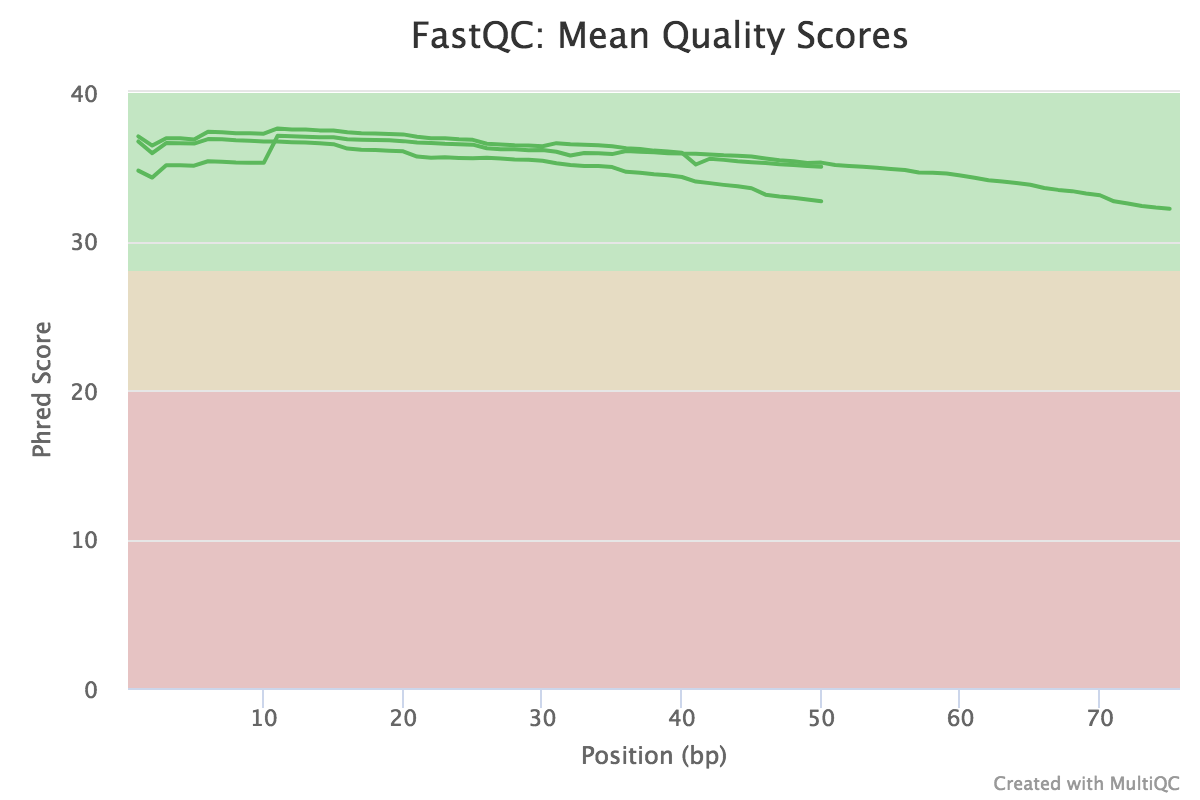

In [24]:
from IPython.display import Image

Image(thyroid_pngs[1])

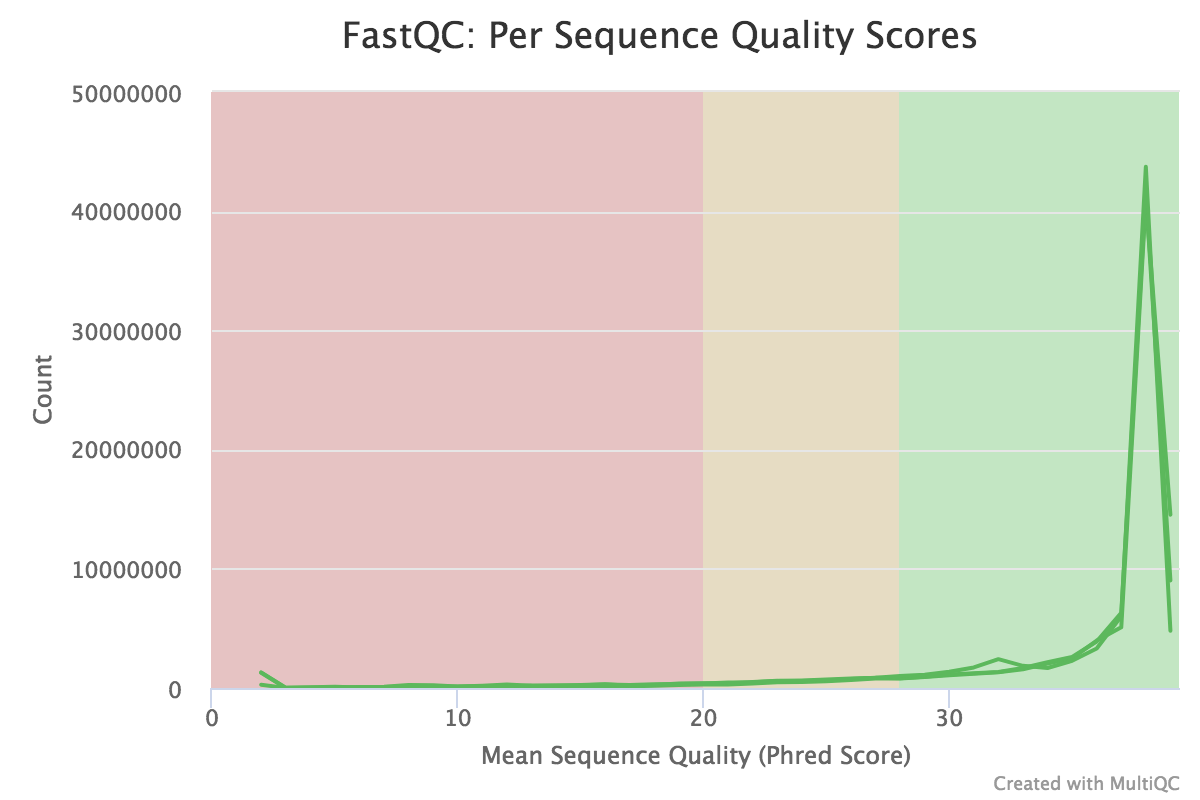

In [25]:
Image(thyroid_pngs[2])

So, surprisingly, the data don't look that bad for the thyroid reads, at least when taken as a whole.  Contrast this to the lousy results seen when just looking at the first 10,000 reads from any dataset when I was verifying their quality on my local machine.  Perhaps the first few spots included in any run are more likely to be skewed to a lower quality when compared to the entirety of the experiment?

Since my main objective with this analysis is to quantification of gene expression across these tissues, I'll also want to make sure that we *do* see some transcripts more than once.  We might not expect the same portion of a transcript to show up in many reads, and therefore sequence duplication levels might not be the most important metric to establish this now, but it still would be good to confirm that there is *some* amount of sequence duplication present in these reads:

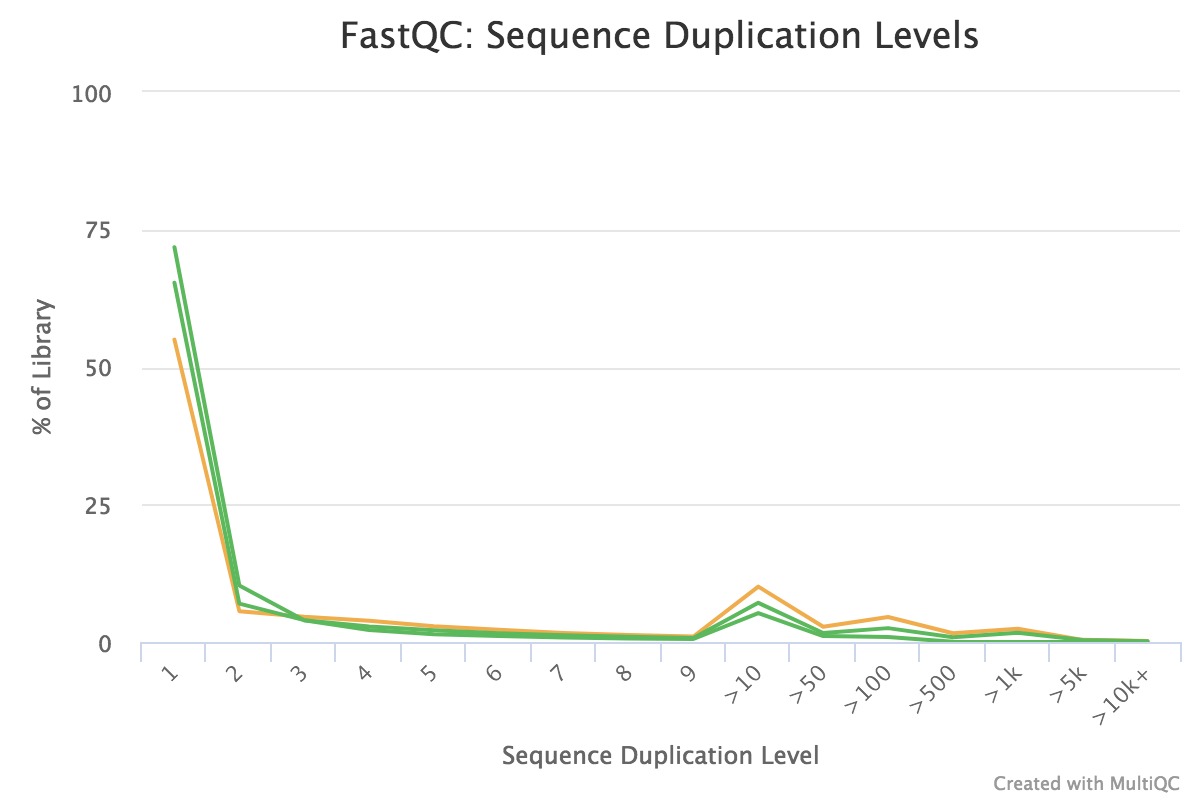

In [26]:
Image(thyroid_pngs[3])

In any case, even though they look mostly fine, it's still clear that the first dozen or so bases do run into the problem listed before about heavy bias in the identity of different nucleotides (unfortunately, MultiQC says that this type of report plot alone doesn't export as a png, so I had to use printscreen, and thus the quality takes a hit):

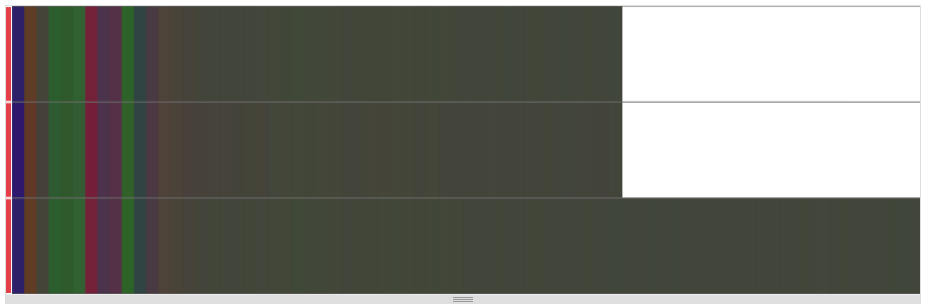

In [28]:
Image(thyroid_pngs[0])

This means that I'll definitely need to trim.  Unfortunately, the `BBTools` suite *doesn't* appear to be available on Galaxy by default:

In [29]:
gi.jobs.get_jobs()
tools = gi.tools.get_tools()
len(tools)

1626

In [30]:
tools[0]

{'panel_section_name': 'NGS: Mothur',
 'description': 'Merge SFF files',
 'labels': ['updated'],
 'edam_operations': [],
 'form_style': 'regular',
 'edam_topics': [],
 'panel_section_id': 'ngs:_mothur',
 'version': '1.36.1.0',
 'link': '/tool_runner?tool_id=toolshed.g2.bx.psu.edu%2Frepos%2Fiuc%2Fmothur_merge_sfffiles%2Fmothur_merge_sfffiles%2F1.36.1.0',
 'target': 'galaxy_main',
 'min_width': -1,
 'model_class': 'Tool',
 'id': 'toolshed.g2.bx.psu.edu/repos/iuc/mothur_merge_sfffiles/mothur_merge_sfffiles/1.36.1.0',
 'tool_shed_repository': {'owner': 'iuc',
  'changeset_revision': 'e7f1da3e0339',
  'name': 'mothur_merge_sfffiles',
  'tool_shed': 'toolshed.g2.bx.psu.edu'},
 'name': 'Merge.sfffiles'}

In [31]:
tool_descriptions = {}

for tool in tools:
    tool_descriptions[tool['name']] = tool['description']

tool_descriptions_S = pd.Series(list(tool_descriptions.values()))
tool_descriptions_S.unique().shape

(776,)

In [32]:
for x in tool_descriptions.keys():
    if 'map' in x:
        print(x)

Filter mapped reads
heatmap2
Heatmap.sim
Heatmap.bin
plotHeatmap
Combine mapped faux paired-end reads
tmap
Heatmap 


Rather, their main tool for editing reads is Trimmomatic.  

Actually, there are alternative, simpler tools that can be run in series, which are based on the [FastX-Toolkit](http://hannonlab.cshl.edu/fastx_toolkit/).  The author of that package even includes docs on how to use it [in the context of Galaxy](http://hannonlab.cshl.edu/fastx_toolkit/galaxy.html).  These simpler steps include trimming by length, trimming by quality, filtering by read quality, clipping adapter sequences, removing 'sequencing artifacts', etc.  I haven't used this suite of tools before, but am intrigued by having these steps split out explicitly, so I'll try it with the thyroid reads:

The options available in the FastX-Tool for trimming by length include specifying a first base to keep; it may be too aggressive, but I'm going to chop the first dozen bases from every read off.  Then I'll use more gentle filtering by read quality (90% of bases within a read must have PHRED>20), clipping adapters, and trying that 'sequencing artifact' removal step.

Actually, after scheduling these steps, I found that the adapter-clipping step had errored out; I wasn't sure how to choose the options for that tool, and apparently failed to supply an input adapter sequence to target.  The tool's window has a dropdown menu that is titled 'Source', and has only two options: 'Standard (select from the list below)', and 'Enter custom sequence'.  There's an empty field below it that's definitely meant to receive input related to this choice, and it's titled 'Choose adapter'.  Rather than feeding it a single adapter sequence, I had gambled that the first option, 'Standard' would pass a default library of adapter sequences, and that these would likely include common Illumina mRNA-seq kit, and further that the '(select from the list below)' part of that line was perhaps misplaced, referring instead to the dropdown window *containing* that line, since there doesn't seem to be another such 'list' anywhere in the tool's form page that would correspond to such a note.

Instead, the tool had apparently expected me to input a single adapter sequence, because the tool stalled with an error (I'm having difficulty, one day later, tracking down the exact string returned by that error, because I'm unsure of the particular BioBlend command syntax to retrieve it).  The man page for the CLI-based version of FastX-Tools [indicates](http://hannonlab.cshl.edu/fastx_toolkit/commandline.html#fastx_clipper_usage) that the clipper tool expects a single custom sequence be input at runtime:

    [-a ADAPTER] = ADAPTER string. default is CCTTAAGG (dummy adapter).
    
Anyways, since subsequent steps were dependent upon the output of that tool in order to execute, the rest of the quality control steps stalled, and as a result the run didn't finish overnight, but needs to be re-run.  That may be an advantage of substituting a tool like Trimmomatic, which executes as a single pipeline, rather than the separate steps of FastX-Tools.  I had checked the Galaxy Main server from my phone after quitting last night, and had seen that the jobs had stalled, but I couldn't supply an adapter easily in that format, so I had tried just deleting the stalled step and the subsequent steps, then calling just the follow-up steps, disregarding the adapter clipping.  But I was unable to figure out how to resume the workflow over my phone at the time.  In fact, when I checked it again today on my PC I still couldn't find a way to resume it.  The workflow steps were highlighted in light blue, saying something like 'this job is paused; select "Resume Paused Jobs" under "History Options" to restart it', but following those instructions had no effect on the workflow.  I tried looking for guidance on that particular issue, but [it sounds like](https://biostar.usegalaxy.org/p/17796/) this may be an acknowledged bug, and my workaround was the most expedient.  Too bad.

Anyways, I'm skipping this adapter clipping step for now; I'm unsure whether it may be a legitimate concern... Actually, I just reviewed the MultiQC report on the raw thyroid reads, and it does include a plot called 'Adapter Content', which indicates that all three Thyroid read files passed whatever threshold FastQC applies for that criterion, but the plot does indicate that adapter content increases towards the end of reads up to a maximum of 0.17% of content towards the 3' end of the SE run (around base 64).  That's not too bad, but if I can get rid of it it's worth adding one more step to the pipeline.  The trace indicates that the identity of the adapter it has detected is the Illumina Universal Adapter.  I consulted Google to get the sequence corresponding to this adapter, and found [this page](https://support.illumina.com/content/dam/illumina-support/documents/documentation/chemistry_documentation/experiment-design/illumina-adapter-sequences-1000000002694-06.pdf).  Although it lists the Universal Adapter under two different contexts (the TruSeq and TruSight kits), they appear to have the exact same sequence.  So I entered that into the FastX-Tools adapter clip step and tacked that step on to the end of the workflows to modify the Thyroid read files.

Those steps are taking a while to run, especially for the SE run (up to 65bp in length, compared to 50bp each for the PE files, although the input file sizes were about the same).  If I check the job history, either through the BioBlend API or the Browser interface, it returns a 'Created' timestamp for the dataset, in UTC, and Google says that 'Coordinated Universal Time is 7 hours ahead of Pacific Time'.  This jibes with my memory in the case of the first trim steps, which I initiated around 8:30PM on 20180710; the timestamp says 'Wed 11 Jul 2018 03:24:49 AM (UTC)'.  The earliest QC steps today (20180711) were started at ~5:45PM, and are still running two hours later.

In [33]:
gi_hist = gi.histories.get_current_history()['id']
gi.histories.get_status(gi_hist)
# gi.jobs.get_state()

{'state': 'error',
 'state_details': {'paused': 0,
  'ok': 37,
  'failed_metadata': 0,
  'upload': 0,
  'discarded': 0,
  'running': 0,
  'setting_metadata': 0,
  'error': 4,
  'new': 0,
  'queued': 0,
  'empty': 0},
 'percent_complete': 90.2439024390244}

## Post-Trim Quality

Ok, let's check the plots from MultiQC after trimming:

In [34]:
if o_s == 'Darwin':
    thyroid_multiqc_plots_dir_2 = '/Users/drew/data/Bio/galaxy/thyroid_multiqc_2_files'

thyroid_pngs_2 = []
for file in os.listdir(thyroid_multiqc_plots_dir_2):
    if file[:7] == 'fastqc_':
        print(file)
        thyroid_pngs_2.append(os.path.join(thyroid_multiqc_plots_dir_2, file))

fastqc_per_base_seq.png
fastqc_per_base_sequence_quality_plot.png
fastqc_per_sequence_quality_scores_plot.png
fastqc_sequence_duplication_levels_plot.png


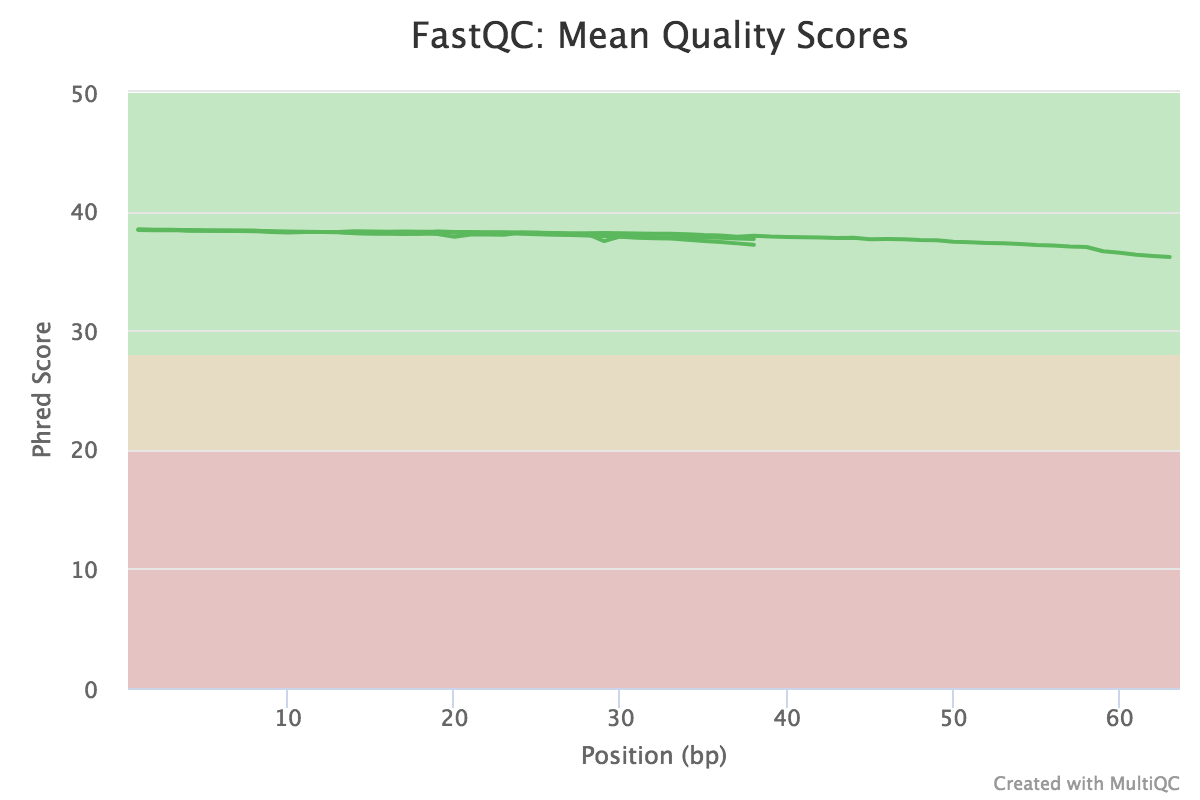

In [35]:
from IPython.display import Image

Image(thyroid_pngs_2[1])

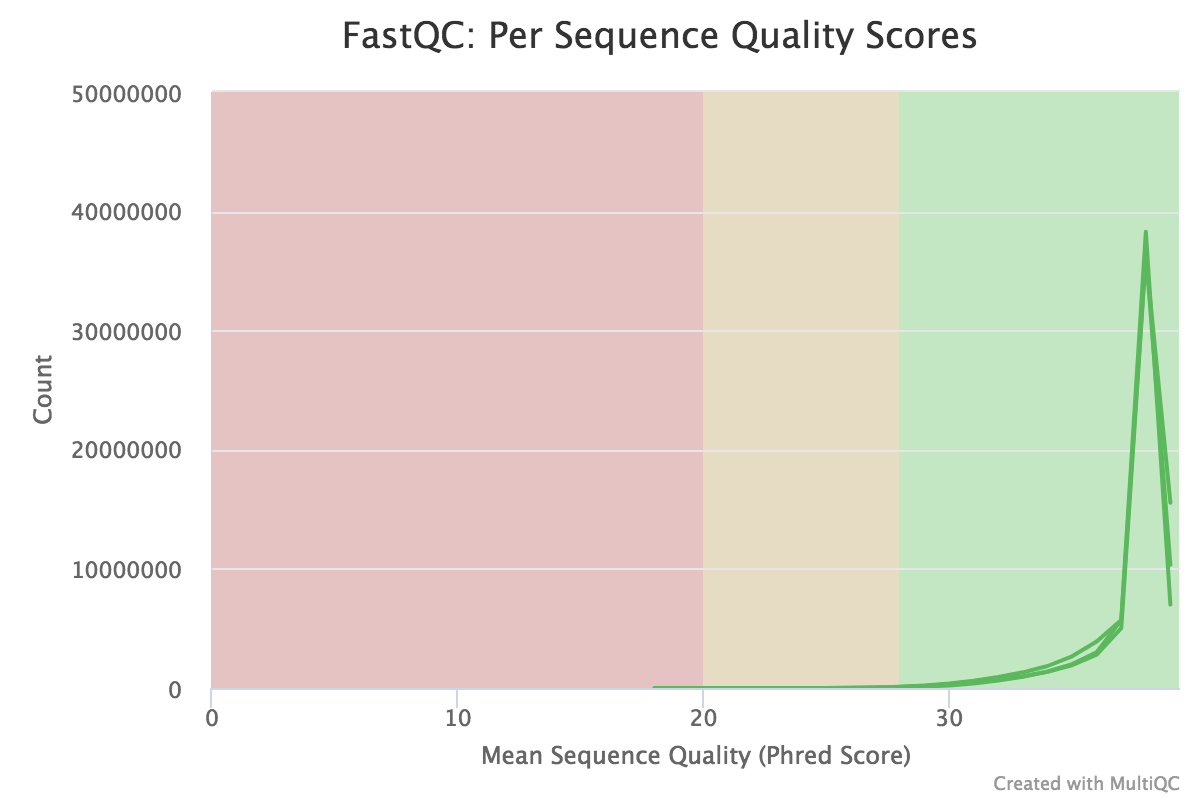

In [36]:
Image(thyroid_pngs_2[2])

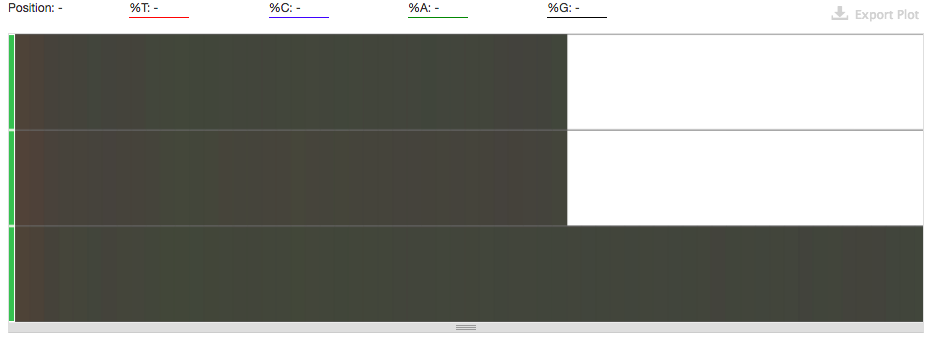

In [37]:
Image(thyroid_pngs_2[0])

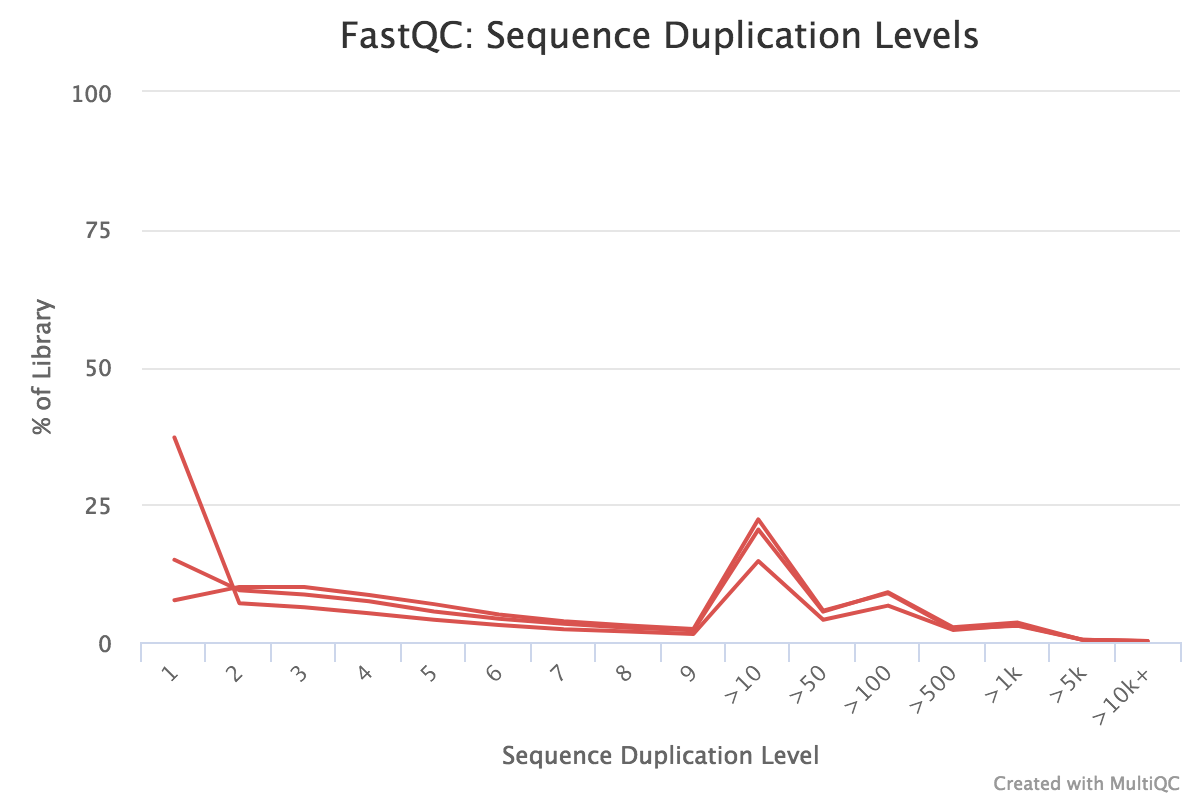

In [38]:
Image(thyroid_pngs_2[-1])

Those all look pretty good.  It's interesting that the representation of sequences that have duplicates actually seems to have increased (i.e., chech out how the peak over the '>10' bin has gotten closer to the '25%' tickmark on the y axis).  Presumably, this occurred at the quality filtering step; trimming the reads shouldn't have increased this score.  It must be that some of the unique reads were of particularly low quality.  This step now actually fails MultiQC's automated cutoff for quality, but I imagine that, if anything, it will make the quantification step more interesting.

## Mapping Reads to Transcripts

As [Conesa et al. 2016](https://doi.org/10.1186/s13059-016-0881-8) points out, when mapping against a transcriptome (as opposed to a genome), you can use an ungapped mapper, and Bowtie is the most popular choice, historically.  If you're aligning against the genome, you have to take into account the mismatch between the intron-containing nature of genomic sequences and the intron-absent (and alternatively spliced) nature of the cDNA from which the reads were amplified; in this case the most popular choice historically has been TopHat.

But furthermore, when mapping reads which represent such short segments of transcriptomes that possess splice variants, the result will be that many, many of the reads will map to multiple different transcripts in the transcriptome equally well, which complicates quantification of gene expression from RNAseq data.

A most straightforward, naive approach would simply be to admit of all multi-mapped reads, and report how many reads aligned to every single transcript or gene in the reference sequence.  But even with this most naive approach, another complication comes from the fact that genes come with different lengths,  and read libraries from which counts are drawn vary in size.  The difficulty with the latter is obvious (total counts will be higher whenever you have more reads), but the problem with the former is simply that longer genes will, for any given copy number, represent a larger number of total nucleotides in the input cDNA library, and therefore be biased towards being represented in more reads than shorter genes.  To make comparisons across different sequencing experiments possible, practitioners have introduced a normalizing parameter, 'reads per kilobase of exon model per million reads', or RPKM.  Further, they state that two derivatives of this measure, 'FPKM (fragments per kilobase of exon model per million mapped reads), a within-sample normalized transcript
expression measure analogous to RPKs, and TPM (transcripts per million) are the most frequently reported RNA-seq gene expression values'.  Finally, and obviously, there are biases in the amplification steps involved in any sequencing protocol, especially in GC content, but also in repetitive sequences or other structural considerations of the template DNA.

As to the proper tools that were built with these issues in mind, I'll just copy verbatim the Conesa_2016 suggestion:

'Algorithms that quantify expression from transcriptome mappings include RSEM (RNA-Seq by Expectation Maximization) [40], eXpress [41], Sailfish [35] and kallisto [42] among others. These methods allocate multi-mapping reads among transcript and output within-sample normalized values corrected for sequencing
biases [35, 41, 43]. Additionally, the RSEM algorithm uses an expectation maximization approach that returns TPM values [40]. NURD [44] provides an efficient way of estimating transcript expression from SE reads with a low memory and computing cost.'

Let's check for which of these are already available to the Galaxy Instance, to see what options I'll have going forward:

In [39]:
looking_for = ['RSEM', 'eXpress', 'RNA-Seq by Expectation Maximization', 'Sailfish', 'Kallisto', 'Salmon', 'NURD', 'Bowtie', 'Tophat', 'Cufflinks']

for x in set(tool_descriptions.keys()):
    for looked in looking_for:
        if looked in x:
            print(x)

Kallisto quant
Sailfish
Convert FASTA to Bowtie base space Index
Bowtie2
Cufflinks
Convert FASTA to Bowtie color space Index
Kallisto pseudo
Tophat
Map with Bowtie for Illumina
Tophat2
Salmon


I should note that Galaxy also separates the (substantial number of; 1,626 as of 20180711) tools already compiled and available to run immediately versus a stable of some others (751 in number as of 20180711) that are available to install prior to running, in the 'toolshed':

In [40]:
toolshed = {}

for tool in gi.toolShed.get_repositories():
    toolshed[tool['name']] = tool['id']

print(len(toolshed))

751


In [41]:
for x in set(toolshed.keys()):
    for looked in looking_for:
        if looked in x:
            print(x)

In [42]:
list(toolshed.keys())[:20]

['allele_counts',
 'analyze_covariates',
 'annotation_profiler',
 'bam_to_sam',
 'bam_to_scidx',
 'bamleftalign',
 'bamtools',
 'bamtools_filter',
 'bamtools_split',
 'basecoverage',
 'bcftools_call',
 'bcftools_view',
 'bedtools',
 'best_regression_subsets',
 'biom_add_metadata',
 'biom_convert',
 'blast_datatypes',
 'blat_coverage_report',
 'blat_mapping',
 'bowtie2']

But apparently, it turns out that none of those missing from the tools list are present in the toolshed.

Additionally, Galaxy itself has a pretty good [overview](https://galaxyproject.org/tutorials/rb_rnaseq/) of the ins and outs of the RNAseq pipeline, and [they say](https://galaxyproject.org/tutorials/rb_rnaseq/) that RPKM, FPKM, and TPM are **not** suitable for comparison of expression levels across samples; they're relative measures.  This seems to conflict from my reading of Conesa2016.  The Galaxy article links to [this blog post](https://haroldpimentel.wordpress.com/2014/05/08/what-the-fpkm-a-review-rna-seq-expression-units/) for further clarification.

All right, I want to set up a first mapping/quantification run, and think I'll try [Sailfish](http://www.cs.cmu.edu/~ckingsf/software/sailfish/index.html) first, since it claims to be pretty fast.  The Galaxy interface for that tool asks first if you want to use a standard transcriptome/index, or supply your own.  I'm doing the latter, with the NCBI version of GRCh38.p12 rna.fa.gz that I uploaded.  Next, they ask for 'The size of the k-mer on which the index is built'; the default in Galaxy's interface is 21, but the [Sailfish FAQ](http://www.cs.cmu.edu/~ckingsf/software/sailfish/faq.html) says that their CLI-based default k-mer count is 31.  They also say that it doesn't appear to be that sensitive a parameter, however, so I'll stick with 21 for the first pass.  The [NCBI Annotation Report](https://www.ncbi.nlm.nih.gov/genome/annotation_euk/Homo_sapiens/109/) doesn't appear to supply any guidance on whether this was a relevant parameter when building the transcriptome and, if so, what value they used.

They also ask, per run, whether the library is SE or PE reads; they don't have an option addressing both, so I guess I'll have to set up separate runs for the two types.  In this history, the fully-trimmed SE file is dataset #53: clip on data 50.  The paired end runs are datasets #51 & 52.

But a little further down, there's a parameter called 'File containing a mapping of transcripts to genes', and says it's looking for a GTF file, and that it's for calculating 'Gene-level abundance estimations', clearly addressing the point I brought up earlier about the distinction between whether you're counting the number of reads that map to a specific transcript or to the concept of a gene more generally in a genome.  The annotation report doesn't mention this, but if you go to the FTP's README file, searching for 'gtf' brings up just 4 hits, in a section titled 'org_transcript.gff.gz and zoo_transcript.gff.gz files', saying that 'These files provide cDNA-to-Genomic, or spliced sequence alignments. These files include same-species and cross-species alignments, respectively. Alignments are generated via the Splign alignment tool'.  It claims that those files are located in the 'MAPVIEW' directory, but there is no such directory located in the top level of the FTP site.  If I navigate to 'ARCHIVE', 'ANNOTATION_RELEASE.108', there is such a dir, but the files within are all empty (they have a 'size' of 0B).  It's the same thing for other ANNOTATION_RELEASEs.

The closest thing I can find appears to be in a subdir called 'GFF', which just contains one file: 'ref_GRCh38.p12_top_level.gff3'.  Its contents look vaguely like a list mapping individual genese to genomic coordinates:

    NC_000001.11    Curated Genomic pseudogene      131068  134836  .       +       .       ID=gene11;Dbxref=GeneID:100420257,HGNC:HGNC:48835;Name=CICP27;description=capicua transc
    riptional repressor pseudogene 27;gbkey=Gene;gene=CICP27;gene_biotype=pseudogene;pseudo=true
    NC_000001.11    Curated Genomic exon    131068  132927  .       +       .       ID=id100;Parent=gene11;Dbxref=GeneID:100420257,HGNC:HGNC:48835;gbkey=exon;gene=CICP27
    NC_000001.11    Curated Genomic exon    132987  133322  .       +       .       ID=id101;Parent=gene11;Dbxref=GeneID:100420257,HGNC:HGNC:48835;gbkey=exon;gene=CICP27
    NC_000001.11    Curated Genomic exon    133733  134058  .       +       .       ID=id102;Parent=gene11;Dbxref=GeneID:100420257,HGNC:HGNC:48835;gbkey=exon;gene=CICP27
    NC_000001.11    Curated Genomic exon    134378  134836  .       +       .       ID=id103;Parent=gene11;Dbxref=GeneID:100420257,HGNC:HGNC:48835;gbkey=exon;gene=CICP27
    NC_000001.11    BestRefSeq      gene    134773  140566  .       -       .       ID=gene12;Dbxref=GeneID:729737;Name=LOC729737;description=uncharacterized LOC729737;gbkey=Gene;g
    ene=LOC729737;gene_biotype=lncRNA
    NC_000001.11    BestRefSeq      lnc_RNA 134773  140566  .       -       .       ID=rna24;Parent=gene12;Dbxref=GeneID:729737,Genbank:NR_039983.2;Name=NR_039983.2;gbkey=ncRNA;gen
    e=LOC729737;product=uncharacterized LOC729737;transcript_id=NR_039983.2
    NC_000001.11    BestRefSeq      exon    140075  140566  .       -       .       ID=id104;Parent=rna24;Dbxref=GeneID:729737,Genbank:NR_039983.2;gbkey=ncRNA;gene=LOC729737;produc
    t=uncharacterized LOC729737;transcript_id=NR_039983.2

But it's not easy to tell whether they'll fit the bill.  Since, however, as I said I can see no other candidate, I'll try passing this file to the program.

In [43]:
gff = os.path.join(paths['data_dir'], 'ref_GRCh38.p12_top_level.gff3.gz')

gi.tools.upload_file(gff, gi_hist)

{'outputs': [{'misc_blurb': None,
   'peek': '<table cellspacing="0" cellpadding="3"></table>',
   'update_time': '2018-07-12T08:44:35.983529',
   'data_type': 'galaxy.datatypes.data.Data',
   'tags': [],
   'deleted': False,
   'history_id': '6129cc23f6415d9a',
   'visible': True,
   'genome_build': '?',
   'create_time': '2018-07-12T08:44:35.715173',
   'hid': 70,
   'file_size': 0,
   'file_ext': 'auto',
   'id': 'bbd44e69cb8906b54fbc8428aa13d834',
   'misc_info': None,
   'hda_ldda': 'hda',
   'history_content_type': 'dataset',
   'name': 'ref_GRCh38.p12_top_level.gff3.gz',
   'uuid': '19452f36-13d0-4db2-aedf-93934cf1b959',
   'state': 'queued',
   'model_class': 'HistoryDatasetAssociation',
   'metadata_dbkey': '?',
   'output_name': 'output0',
   'purged': False}],
 'implicit_collections': [],
 'jobs': [{'tool_id': 'upload1',
   'update_time': '2018-07-12T08:44:36.393036',
   'exit_code': None,
   'state': 'new',
   'create_time': '2018-07-12T08:44:36.080710',
   'model_class': '

After this, there were a number of arguments that I left in their default mode.  Then there's a field called 'Caculate Effective Lengths', whose default value is 200.  I couldn't figure out what this meant, until I read the next field, called 'Standard deviation', whose description made me think it's asking for read lengths.  But the [Sailfish docs](http://sailfish.readthedocs.io/en/master/sailfish.html#quantification) don't mention this parameter, nor the follow-on options.  I think I'll leave all of these at their default values and just run for now.

That scheduled; we'll see what the output is.  I also want to start a paired-end run with Sailfish, and specified that 'Mate pair 1' is dataset '#51 Clip on data 48', that 'Mate pair 2' is dataset '#52 Clip on data 49', and furthermore that 'Relative orientation of reads within a pair' is 'Mates are oriented toward each other (I = inward)'.  I passed the same ref_GRCh38.p12_top_level.gff3.gz file as the 'File containing a mapping of transcripts to genes', left other params as their defaults, and scheduled the run.

While I was setting up the PE run, however, the jobs associated with the SE run turned red in the history, indicating that they had failed.  The same issue eventually occurred with the PE run.  When I clicked on the jobs, the error message was:

    This job was terminated because it used more memory than it was allocated.
    Please click the bug icon to report this problem if you need help.
    
When I check the info associated with the run, however, it shows all of the options I had set, and none of them refer to the amount of memory to allocate.

I googled the error, and found [this post](https://biostar.usegalaxy.org/p/10011/), which makes it pretty clear that the dataset is too large for the memory allocated to all free users of the Galaxy Main server.  Essentially, the recommendation from the Galaxy admins is to move to using the Galaxy Cloudman server, with AWS support.  I'm not sure I'm ready to do this right now, maybe the better option is to split/downsize the read files, and try again?  Unfortunately, I don't see any tools available to do this on the Galaxy Main page; it'll probably require downloading the trimmed Thyroid read files, splitting them locally, then re-uploading and trying again.  Clearly, Galaxy Main's server is insufficient to complete this analysis pipeline with the entire BodyMap dataset, but seeing partial output with a far larger number of reads than I can accomplish on a laptop would still be edifying.  Eventually, of course, I'll have to bite the bullet and pay for some AWS access to see the whole thing.

In [44]:
gi_hist = gi.histories.get_current_history()['id']
gi.histories.get_status(gi_hist)
# gi.jobs.get_state()

{'state': 'queued',
 'state_details': {'paused': 0,
  'ok': 37,
  'failed_metadata': 0,
  'upload': 0,
  'discarded': 0,
  'running': 0,
  'setting_metadata': 0,
  'error': 4,
  'new': 0,
  'queued': 1,
  'empty': 0},
 'percent_complete': 88.0952380952381}

In [46]:
# gi.workflows.export_workflow_dict()
errors = gi.histories.get_current_history()['state_ids']['error']
jobs = gi.jobs.get_jobs()
running_jobs = []
errored_jobs = []
for d in jobs:
    if d['state'] == 'running':
        running_jobs.append(d['id'])
    elif d['state'] == 'error':
        errored_jobs.append(d['id'])

# gi.jobs.show_job(errored_jobs[0])
# gi.jobs.show_job(running_jobs[0])